# Bayesian Hyperparameter Optimization
For this image classification task, `EfficientNet-B0` model was selected. The final classifier is replaced with an 8-class linear head (producing 8 logits).

Hyperparameters are tuned with Optuna to maximize macro-F1 on the validation set, a criterion suited to imbalanced labels, with the goal of robust generalization.

In [1]:
import sys, os
import json
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn as nn
from torchvision import models

import optuna
import pandas as pd
from IPython.display import Image

from src.data import get_datasets
from src.utils import set_device, is_mbconv, EarlyStopper
from src.train import train_step, val_step

In [2]:
# Configurations
DEVICE = set_device()

datasets = get_datasets(root="../data/augmented_images")
output_dir = "../outputs/param-optim"
full_train_ds = datasets["train"]
full_val_ds = datasets["val"]

Device: mps


I am going to use the Optuna framework for Bayesian hyperparameter optimization. Unlike a basic grid search, this method selects new hyperparameter combinations based on previous trial results, making the search much more efficient.

Four main hyperparameters are tuned in this process:

1. Learning Rate

2. Batch Size

3. Weight Decay

4. Number of Unfrozen Layers

In [3]:
# Define the hyperparameters to be tuned
TUNING_RANGES = {
    "LR": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    "BATCH_SIZE": {"type": "categorical", "choices": [16, 32, 64]},
    "WEIGHT_DECAY": {"type": "float", "low": 1e-4, "high": 8e-3, "log": True},
    "UNFREEZE_K": {"type": "int", "low": 2, "high": 8},
}

EPOCHS_PER_TRIAL = 7
N_TRIALS = 100

## 1. Per-trial training setup

- **Loss:** Cross-entropy

- **Optimizer:** AdamW

- **LR schedule:** Cosine annealing

- **Early stopping:** Monitors validation macro-F1 (mode = max) with patience and an overfitting check on (val_loss − train_loss)

- **Fine-tuning:** Progressive unfreezing of the last K MBConv blocks

In [4]:
def objective(trial):
    """A single training run, called by Optuna for each trial."""
    
    # 1. Suggest Hyperparameters Dynamically
    params = {}
    for name, p in TUNING_RANGES.items():
        if p['type'] == 'categorical':
            params[name] = trial.suggest_categorical(name, p['choices'])
        elif p['type'] == 'int':
            params[name] = trial.suggest_int(name, p['low'], p['high'])
        elif p['type'] == 'float':
            params[name] = trial.suggest_float(name, p['low'], p['high'], log=p.get('log', False))

    # 2. Setup Model and Training Components
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    in_features = model.classifier[-1].in_features
    model.classifier = nn.Linear(in_features, 8)
    model.to(DEVICE)
    
    # --- Progressive Unfreezing Logic ---
    for p in model.features.parameters(): p.requires_grad = False
    mbconv_blocks = [m for m in model.features.modules() if is_mbconv(m)]
    K = min(params['UNFREEZE_K'], len(mbconv_blocks))
    for m in mbconv_blocks[-K:]:
        for p in m.parameters(): p.requires_grad = True
    for p in model.features[-1].parameters(): p.requires_grad = True
    for p in model.classifier.parameters(): p.requires_grad = True
        
    # --- Dataloaders, Optimizer, etc. ---
    pin = torch.cuda.is_available()
    train_loader = torch.utils.data.DataLoader(
        full_train_ds, 
        batch_size=params['BATCH_SIZE'], 
        shuffle=True, 
        pin_memory=pin
    )
    val_loader = torch.utils.data.DataLoader(
        full_val_ds, 
        batch_size=params['BATCH_SIZE'],
        pin_memory=pin
    )
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=params['LR'], weight_decay=params['WEIGHT_DECAY'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_PER_TRIAL)
    
    # 3. Training Loop
    early_stopper = EarlyStopper(mode="max", patience=3, max_overfit_gap=0.10)
    best_f1 = 0.0
    best_metrics_for_trial = {}

    for epoch in range(1, EPOCHS_PER_TRIAL + 1):
        train_metrics = train_step(model, train_loader, criterion, optimizer, DEVICE, disable_tqdm=True)
        val_metrics = val_step(model, val_loader, criterion, DEVICE, disable_tqdm=True)
        scheduler.step()
        
        val_f1 = val_metrics['f1_macro']
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            # You can keep this logic to store the best metrics for the trial
            best_metrics_for_trial = {
                "val_f1_macro": val_metrics['f1_macro'],
                "val_precision": val_metrics['precision_macro'],
                "val_recall": val_metrics['recall_macro'],
                "val_accuracy": val_metrics['accuracy'],
                "val_loss": val_metrics['loss'],
                "train_f1_macro": train_metrics['f1_macro'],
                "train_accuracy": train_metrics['accuracy'],
                "train_loss": train_metrics['loss'],
                "epoch": epoch
            }
            
        # Optuna pruning logic
        trial.report(val_f1, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        # Early Stopping
        _, should_stop, _ = early_stopper.step(
            val_patience_metric=val_metrics['f1_macro'],
            train_loss=train_metrics['loss'],
            val_loss=val_metrics['loss']
        )
        if should_stop:
            break
    
    trial.set_user_attr("best_metrics", best_metrics_for_trial)
    
    return best_f1

## 2. Run the Study
To speed up the process, a MedianPruner is used to stop unpromising trials early.

Additionally, through empirical observation, the model tends to overfit rapidly. To mitigate this, early stopping was applied based on the gap between the training and validation F1 macro scores, ensuring that training halts once overfitting becomes evident.

In [5]:
# Silence Optuna
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
optuna.logging.disable_default_handler()

# Create a study object and specify the direction is to maximize the F1 score
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())

try:
    # Start the optimization process
    study.optimize(objective, n_trials=N_TRIALS, timeout=3600)
except KeyboardInterrupt:
    print("Study interrupted manually. Results up to this point will be shown.")
    
print("\n" + "="*50)
print("HYPERPARAMETER TUNING COMPLETE")
print(f"Number of finished trials: {len(study.trials)}")


HYPERPARAMETER TUNING COMPLETE
Number of finished trials: 100


## 3. Results

In [6]:
print("--- Best Trial ---")
best_trial = study.best_trial

print(f"Value (val_f1_macro): {best_trial.value:.4f}")
print("Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

--- Best Trial ---
Value (val_f1_macro): 0.8248
Params: 
    LR: 0.0005166220745343162
    BATCH_SIZE: 32
    WEIGHT_DECAY: 0.0012417105715509208
    UNFREEZE_K: 4


In [7]:
print("\n--- Full Metrics for Best Trial ---")
best_metrics = best_trial.user_attrs.get("best_metrics", {})
print(pd.Series(best_metrics).to_string())


--- Full Metrics for Best Trial ---
val_f1_macro      0.824761
val_precision     0.821521
val_recall        0.835569
val_accuracy      0.831776
val_loss          0.604473
train_f1_macro    0.846376
train_accuracy    0.846394
train_loss        0.470283
epoch             2.000000


In [9]:
file_path = os.path.join(output_dir, "best_hyperparameters.json")

with open(file_path, 'w') as f:
    json.dump(best_trial.params, f, indent=4)

print("Best hyperparameters are saved!")

Best hyperparameters are saved!


Those hyperparameters will be used for the training of the model for our classification task.

In [10]:
# --- Create a DataFrame with full results from all trials ---
all_trials = []
for trial in study.trials:
    if trial.state == optuna.trial.TrialState.COMPLETE:
        trial_metrics = trial.user_attrs.get("best_metrics", {})
        # Combine hyperparameters and the resulting metrics
        row = {**trial.params, **trial_metrics}
        all_trials.append(row)

results_df = pd.DataFrame(all_trials)

# Add the overfitting gap and sort
if 'train_accuracy' in results_df.columns and 'val_accuracy' in results_df.columns:
    results_df['overfit_gap'] = results_df['train_f1_macro'] - results_df['val_f1_macro']

sorted_df = results_df.sort_values(by="val_f1_macro", ascending=False).reset_index(drop=True)

pd.set_option('display.width', 120)
display(sorted_df.head(5))

,LR,BATCH_SIZE,WEIGHT_DECAY,UNFREEZE_K,val_f1_macro,val_precision,val_recall,val_accuracy,val_loss,train_f1_macro,train_accuracy,train_loss,epoch,overfit_gap
0,0.000517,32,0.001242,4,0.824761,0.821521,0.835569,0.831776,0.604473,0.846376,0.846394,0.470283,2,0.021614
1,0.000538,32,0.000340,7,0.807825,0.811286,0.811467,0.803738,0.659994,0.623691,0.623776,1.171619,1,-0.184134
2,0.000357,32,0.000211,6,0.792434,0.811860,0.792999,0.803738,0.613897,0.839395,0.840160,0.534621,2,0.046961
3,0.000519,32,0.000992,6,0.791103,0.806472,0.789582,0.794393,0.606643,0.858615,0.859305,0.446965,2,0.067512
4,0.000355,32,0.000963,2,0.790102,0.782401,0.804620,0.785047,0.664369,0.864029,0.864648,0.461709,3,0.073927


In [11]:
file_path = os.path.join(output_dir, "hyperparam-optim-results.csv")

sorted_df.to_csv(file_path)

print("All results are saved!")

All results are saved!


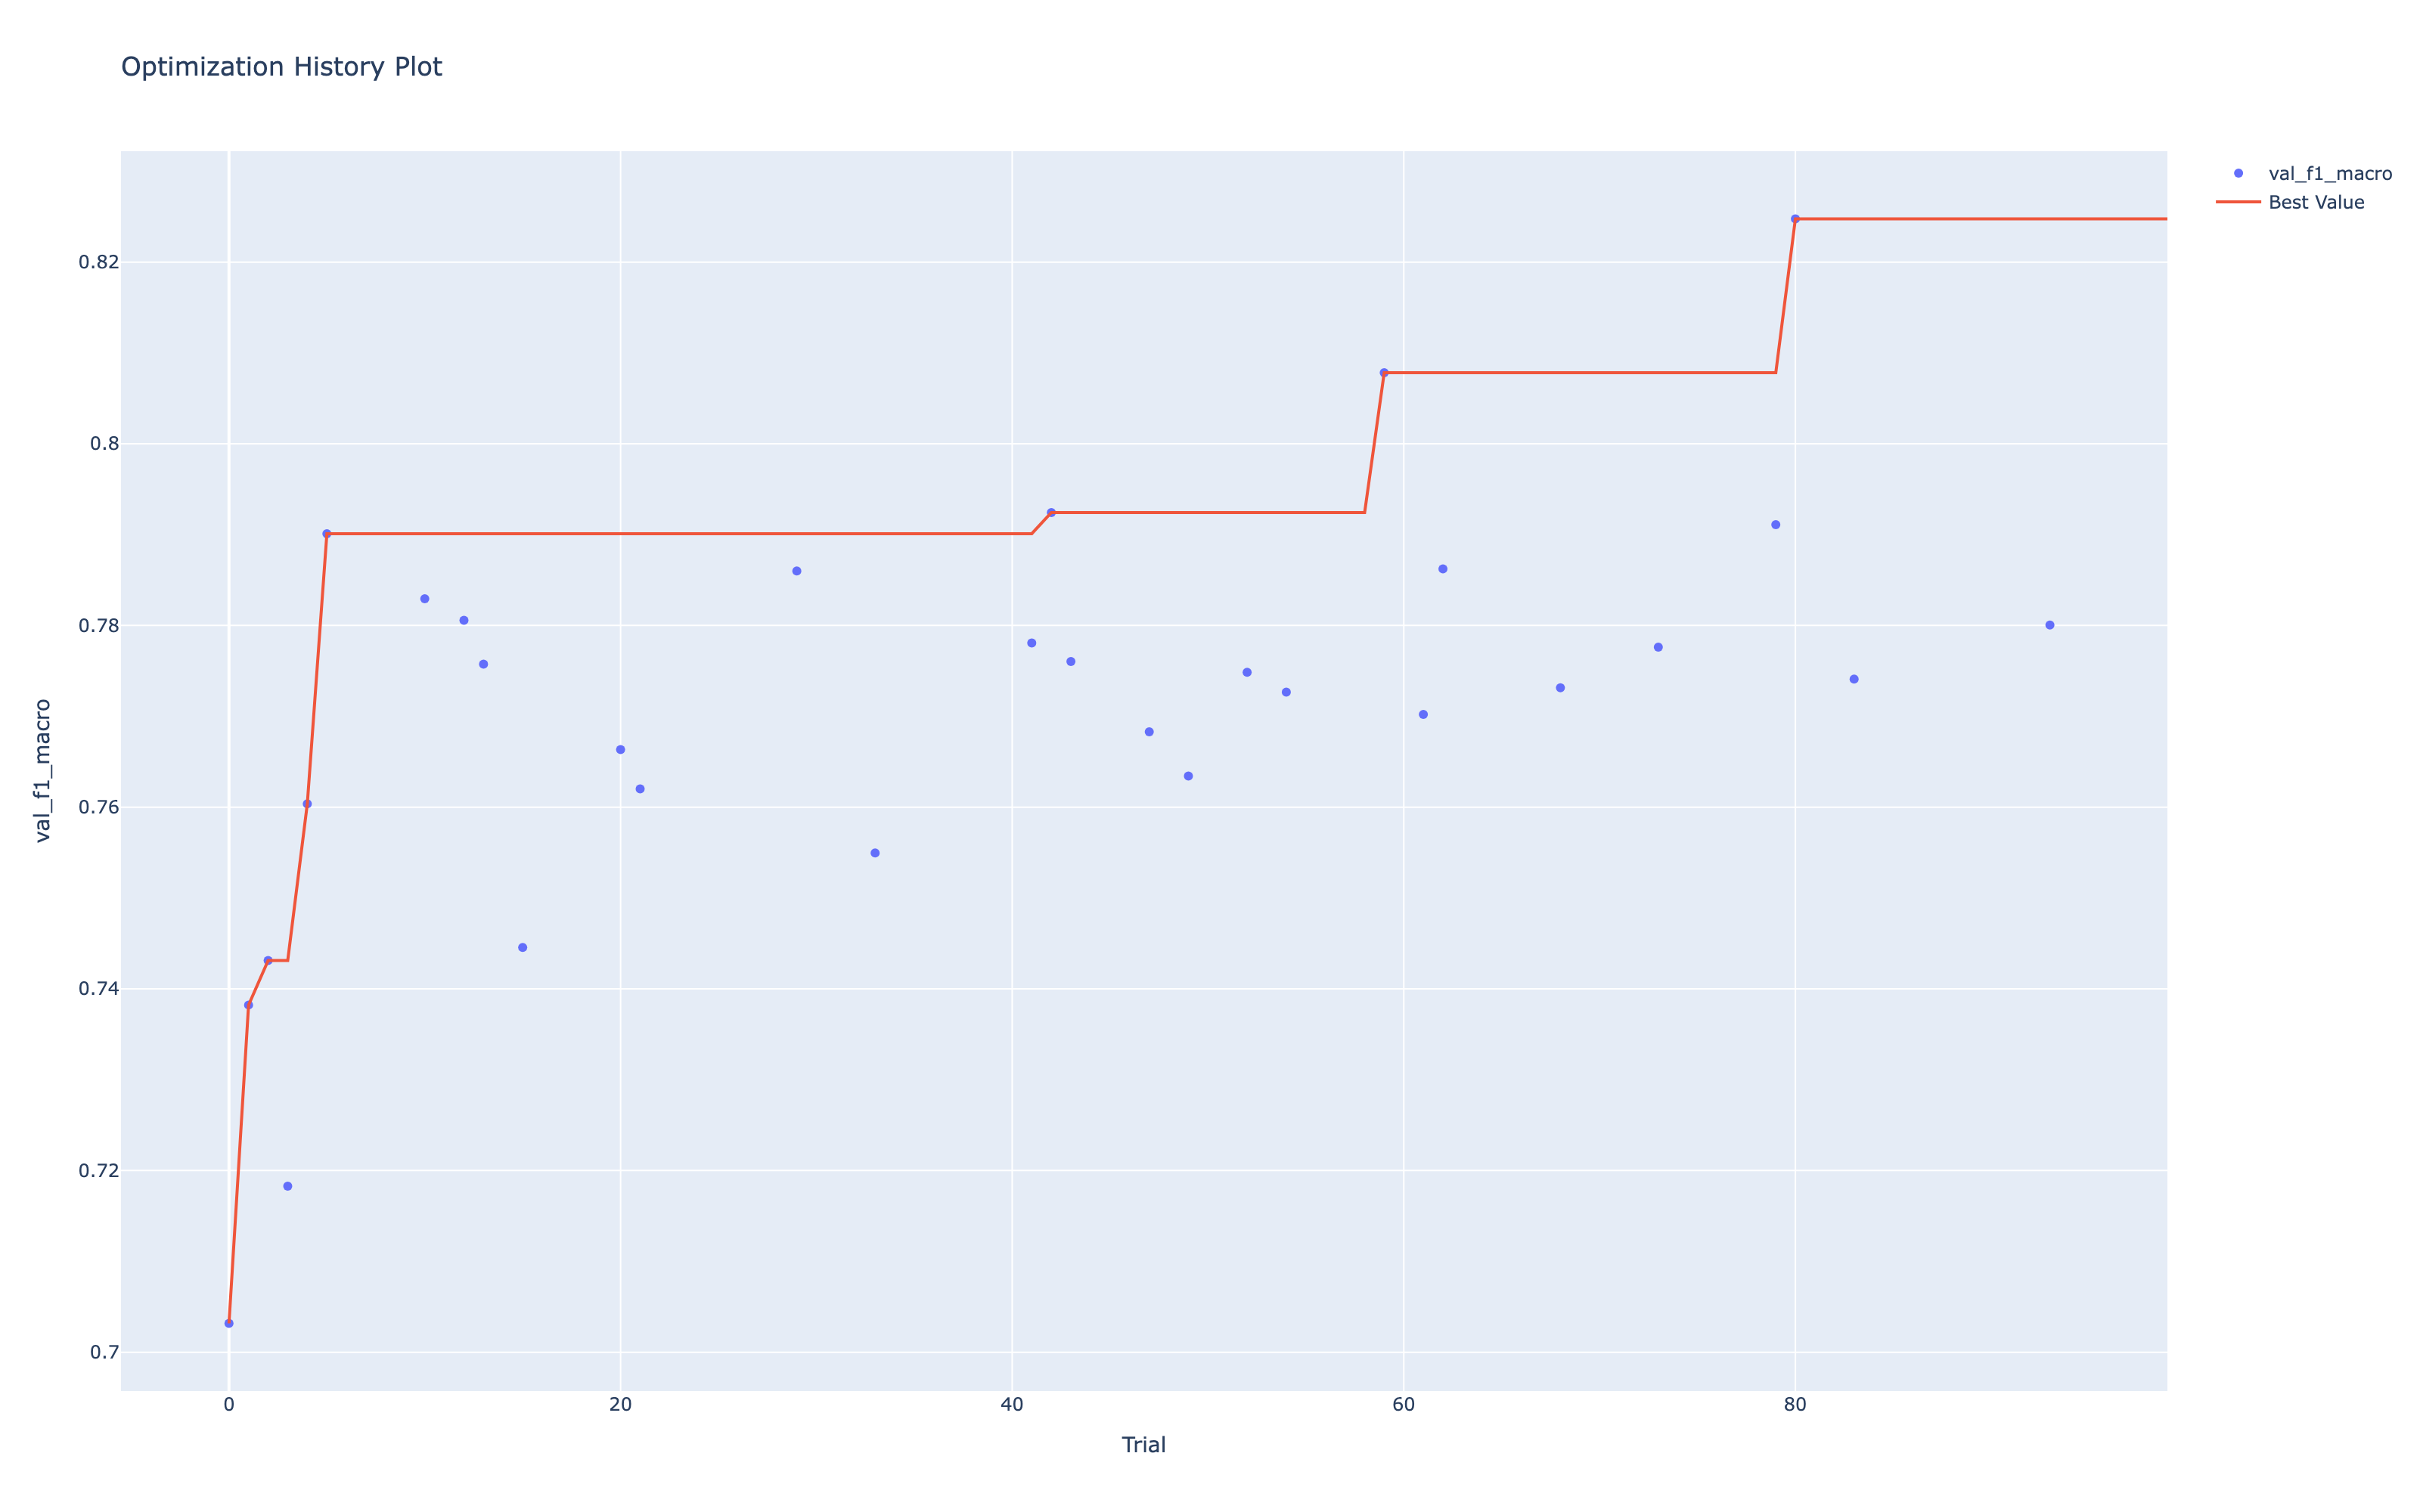

In [12]:
# Shows how the F1-score improved over trials
fig = optuna.visualization.plot_optimization_history(study, target_name="val_f1_macro")
file_path = os.path.join(output_dir, "optimization_history.png")
fig.write_image(file_path, width=1600, height=1000, scale=2)

# Display it in the notebook
Image(filename=file_path)

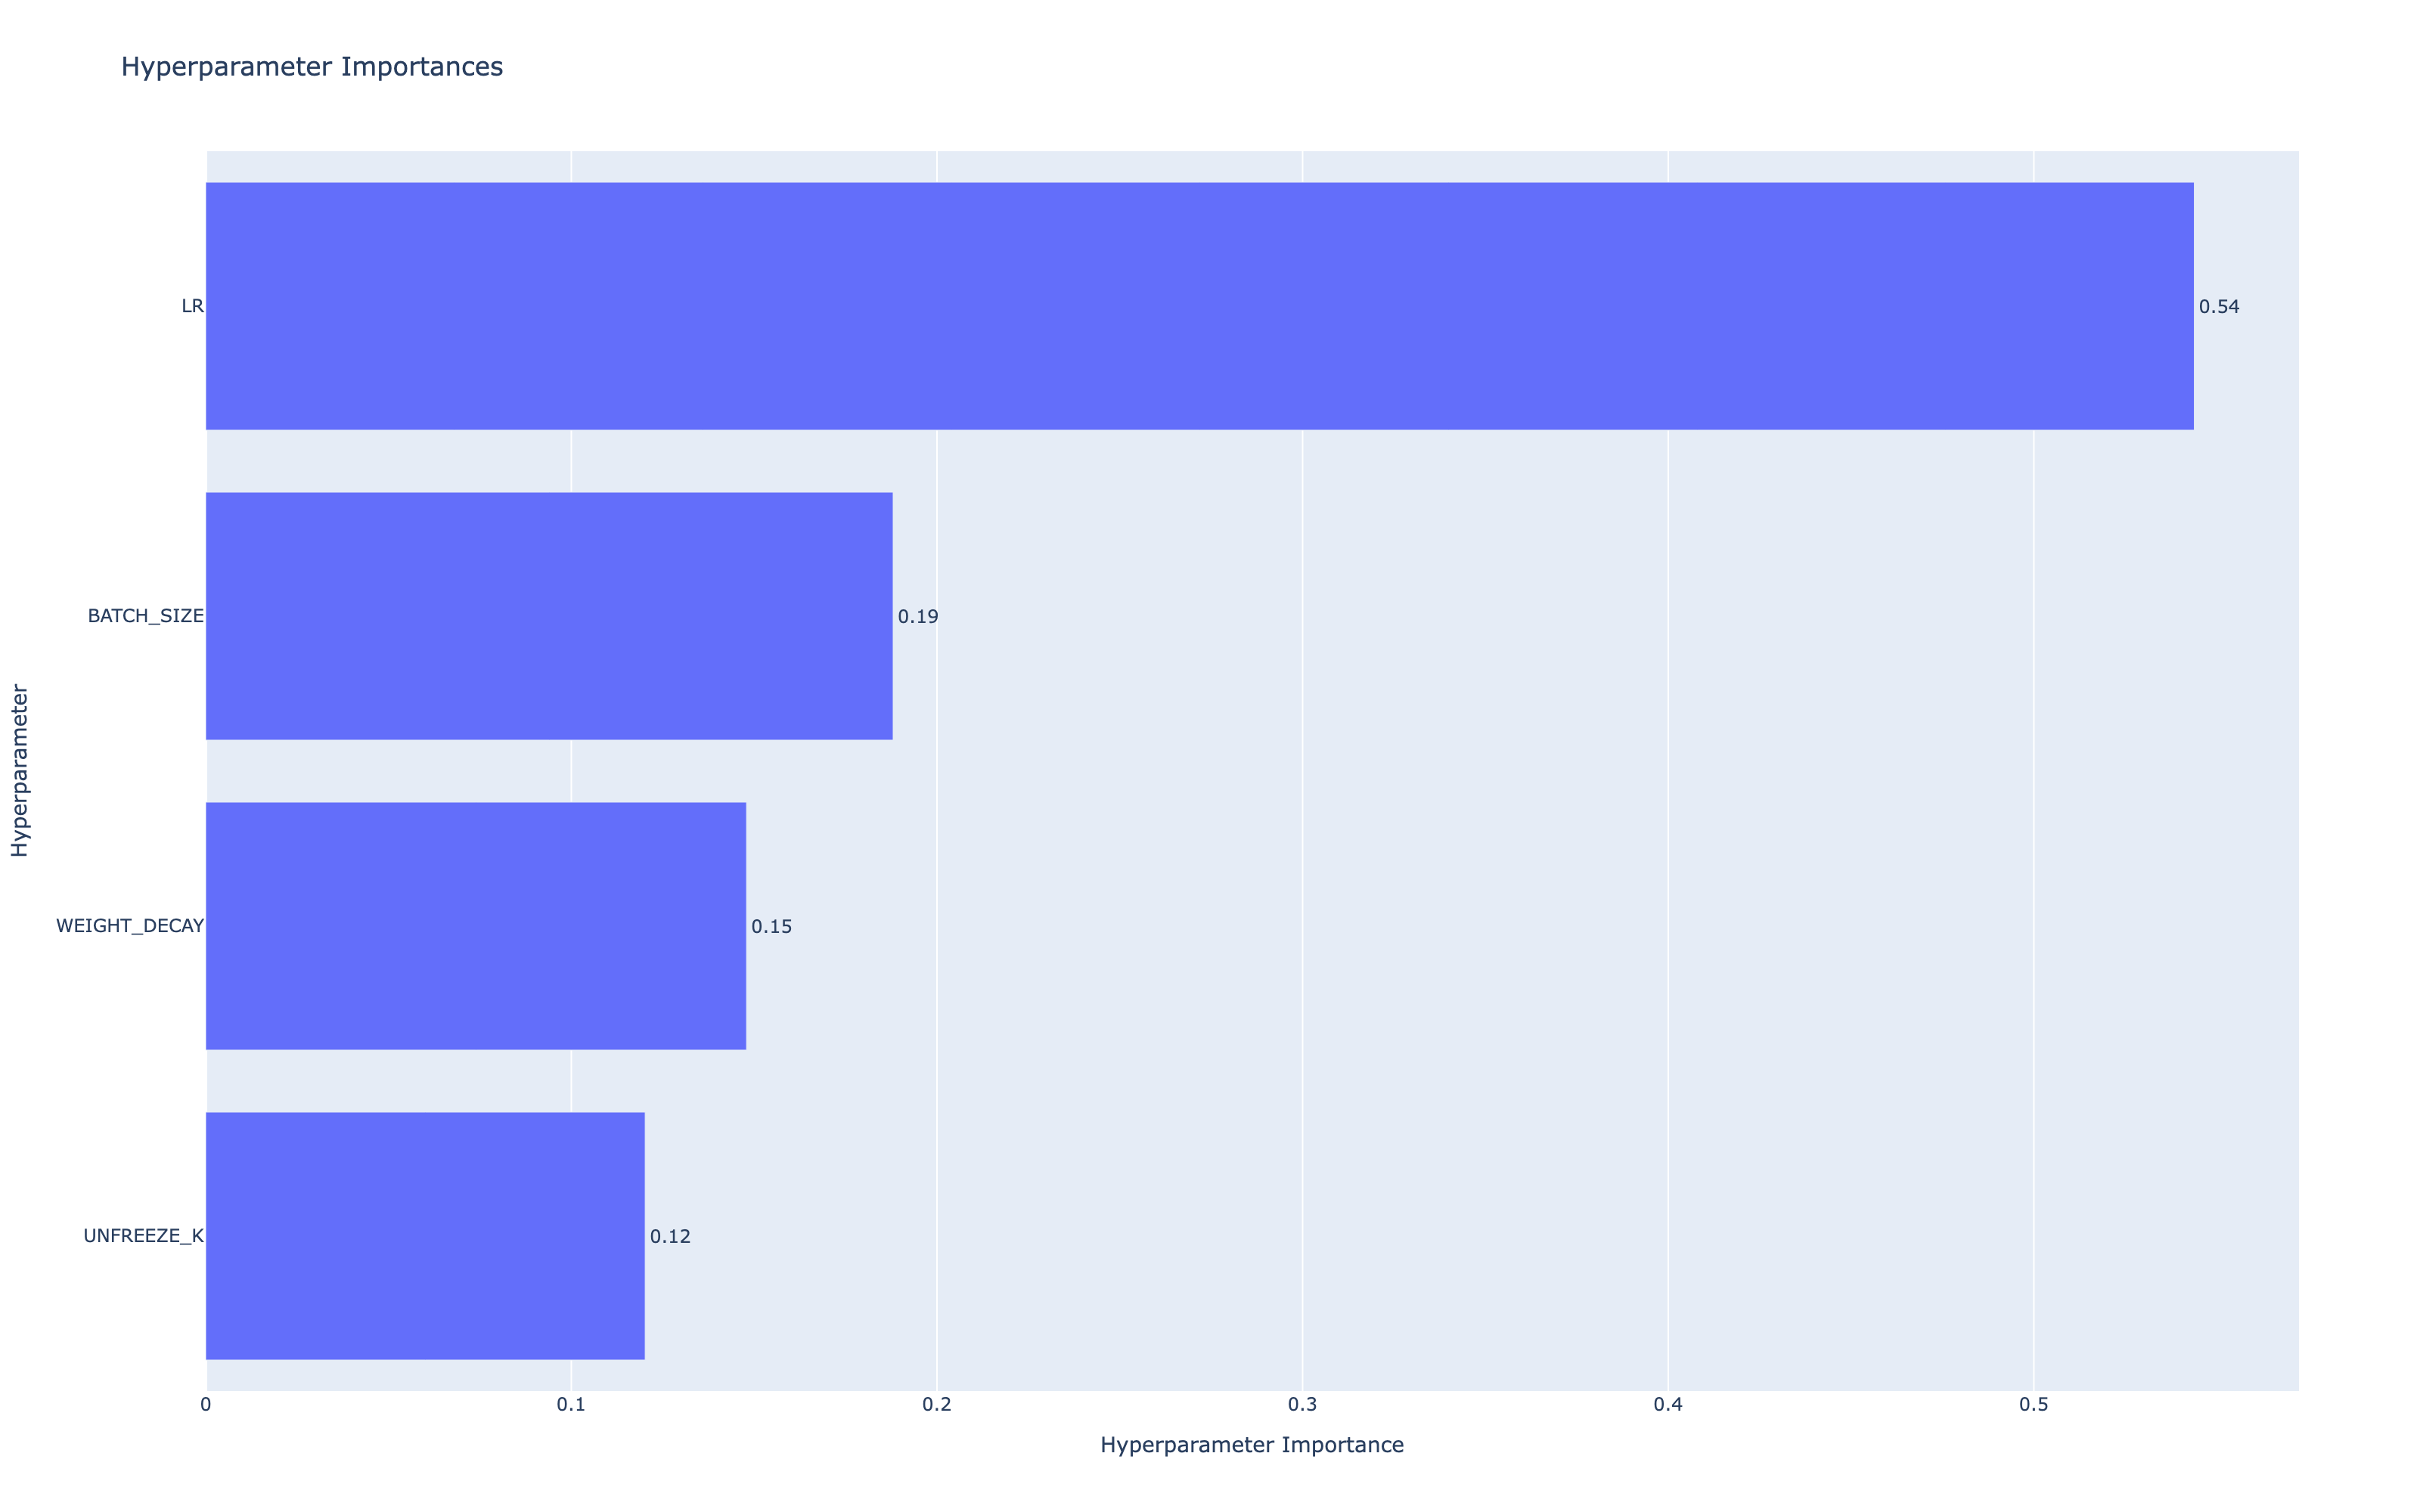

In [13]:
# Shows which hyperparameters were most important
fig = optuna.visualization.plot_param_importances(study, target_name="val_f1_macro")
file_path = os.path.join(output_dir, "param-importances.png")
fig.write_image(file_path, width=1600, height=1000, scale=2)

# Display it in the notebook
Image(filename=file_path)

The hyperparameter importance analysis indicates that learning rate and batch size had the largest impact on model performance.

## 4. Conclusion
Hyperparameters with the highest validation macro-F1 are saved and used to train the final model.
Training converges in a few epochs (by epoch 2) with a modest train–validation gap (≈0.07 F1; loss gap ≈0.17), indicating mild overfitting but solid validation performance.

For final training, early stopping will monitor the loss gap between training and validation and stop if it grows too large (unlike the hyperparameter search, which used an F1-based criterion).